In [35]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, concatenate
import matplotlib.pyplot as plt

## Link to my blog:
https://medium.com/@chuqing_wang/image-similarity-assessment-using-neural-networks-b8f965aceb6b

In [23]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [24]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_train = x_train / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test / 255
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print("train")
print(x_train.shape)
print("test")
print(x_test.shape)

train
(60000, 28, 28, 1)
test
(10000, 28, 28, 1)


In [25]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups')
print([x.shape[0] for x in train_groups])
print('test groups')
print([x.shape[0] for x in test_groups])

train groups
[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [28]:
def genBatch(inputs, size = 8):
    output_1 = []
    output_2 = []
    score = [] 
    groups = list(range(len(inputs)))
    for match in [True, False]:
        idx = np.random.choice(groups, size = size)
        output_1 += [inputs[x][np.random.choice(range(inputs[x].shape[0]))] for x in idx]
        if match:
            idx_2 = idx
            score += [1]*size
        else:
            # anything but the same group
            idx_non = [np.random.choice([i for i in groups if i!=y]) for y in idx] 
            idx_2 = idx_non
            score += [0]*size
            
        output_2 += [inputs[z][np.random.choice(range(inputs[z].shape[0]))] for z in idx_2]
            
    return np.stack(output_1,0), np.stack(output_2,0), np.stack(score,0)

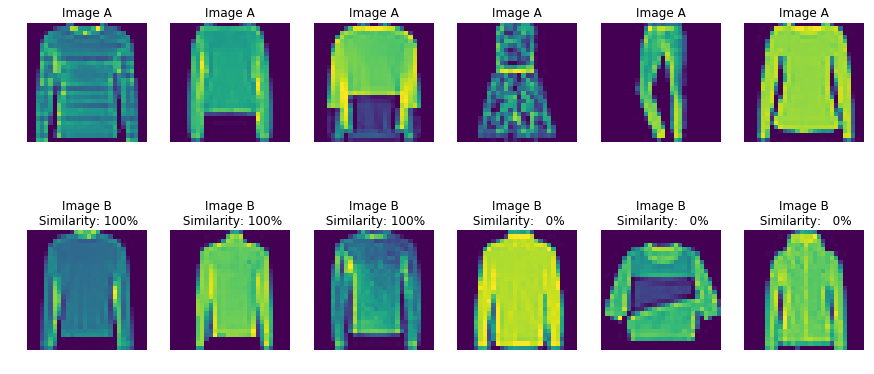

In [32]:
%matplotlib inline
a, b, similarity = genBatch(train_groups, 3)
fig, m_axs = plt.subplots(2, a.shape[0], figsize = (15, 7))
for x, y, z, (ax1, ax2) in zip(a, b, similarity, m_axs.T):
    ax1.imshow(x[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(y[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*z))
    ax2.axis('off')

## Feature Generation Model

In [34]:
input_ = Input(shape = x_train.shape[1:], name = 'Image_Input')
model = input_

model = Conv2D(16, kernel_size = (3,3), activation = 'linear')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(32, kernel_size = (3,3), activation = 'linear')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPool2D((2,2))(model)

model = Conv2D(32, kernel_size = (3,3), activation = 'linear')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = Conv2D(64, kernel_size = (3,3), activation = 'linear')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
model = MaxPool2D((2,2))(model)

model = Flatten()(model)
model = Dense(32, activation = 'linear')(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
feature_generation_model = Model(inputs = [input_], outputs = [model], name = 'Feature_Generation_Model')
feature_generation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 24, 24, 32)        0         
__________

## Similarity Model

In [36]:
inputA = Input(shape = x_train.shape[1:], name = 'ImageA')
inputB = Input(shape = x_train.shape[1:], name = 'ImageB')
featA = feature_generation_model(inputA)
featB = feature_generation_model(inputB)

model_merge = concatenate([featA, featB], name = 'merge_features')
model_merge = Dense(16, activation = 'linear')(model_merge)
model_merge = BatchNormalization()(model_merge)
model_merge = Activation('relu')(model_merge)
model_merge = Dense(4, activation = 'linear')(model_merge)
model_merge = BatchNormalization()(model_merge)
model_merge = Activation('relu')(model_merge)
model_merge = Dense(1, activation = 'sigmoid')(model_merge)

similarity_model = Model(inputs = [inputA, inputB], outputs = [model_merge], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ImageB (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Feature_Generation_Model (Model (None, 32)           66048       ImageA[0][0]                     
                                                                 ImageB[0][0]                     
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           Feature_Generation_Model[1][0]   
          

In [37]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

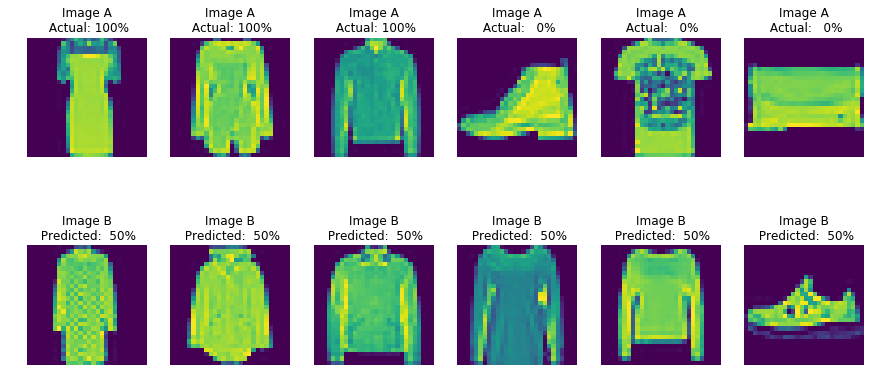

In [41]:
def show_result(num_ex = 3):
    a, b, sim = genBatch(test_groups, num_ex)
    pred = similarity_model.predict([a, b])
    fig, m_axs = plt.subplots(2, a.shape[0], figsize = (15, 7))
    for x, y, z, d, (ax1, ax2) in zip(a, b, sim, pred, m_axs.T):
        ax1.imshow(x[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*z))
        ax1.axis('off')
        ax2.imshow(y[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*d))
        ax2.axis('off')
    return fig
# a completely untrained model
result_ = show_result()